In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.rcParams["figure.figsize"] = (15, 5)

**Import and prepare data**

Add extra columns

In [3]:
def prepare_data(coin):
    df = pd.read_csv(f'../data/coin_{coin}.csv', index_col=0).reset_index()
    df.Date = pd.to_datetime(df.Date)
    df['dayofweek'] = df.Date.dt.dayofweek
    df['dayofmonth'] = df.Date.dt.day
    df['year_month'] = df.Date.dt.strftime("%Y-%m")
    df['avg_daily_price']= (df.High + df.Low) / 2
    return df

**Calculate profit**

Given the provided dataframe for a specific coin, and the configuration for the frequency of the DCA plan, calculate the profit in percantage accumulated over the specified time window.

In [4]:
def calculate_profit_dca(df, frequency, purchase_year_month = '2018-01',\
                        purchase_day_of_week = 0, purchase_day_of_month = [0]):
    purchase_usd = 10
    if frequency == 'monthly':
        freq_cond = (df.dayofmonth.isin(purchase_day_of_month))
        if(31 in purchase_day_of_month):
            # Take last day of months with 30 days
            freq_cond = freq_cond | (df.Date.dt.month.isin([11,4,6,9]) & (df.dayofmonth == 30))
        if((31 in purchase_day_of_month) or (30 in purchase_day_of_month)):
            # Take last day of February (29th in case of leap year)
            freq_cond = freq_cond |\
                        (df.Date.dt.year.isin([2008, 2012, 2016, 2020, 2024, 2028, 2032, 2036, 2040, 2044]) &\
                         df.Date.dt.month.isin([2]) & (df.dayofmonth == 29))
        if((31 in purchase_day_of_month) or (30 in purchase_day_of_month) or (29 in purchase_day_of_month)):     
            # In case 29 is the day, use 28 for February in non leap year
            freq_cond = freq_cond |\
                        ((~df.Date.dt.year.isin([2008, 2012, 2016, 2020, 2024, 2028, 2032, 2036, 2040, 2044])) &\
                         df.Date.dt.month.isin([2]) & (df.dayofmonth == 28))          
    if frequency == 'weekly':
        freq_cond = (df.dayofweek == purchase_day_of_week)

    purchase = df[(df.year_month >= purchase_year_month) & freq_cond]
    purchased_amount = (purchase_usd/purchase.High).sum()
    investment_amount = purchase_usd * len(purchase)
    investment_value = df[-1:].High * purchased_amount
    return (investment_value / investment_amount)

The considered coins

In [5]:
coins = ['Cardano']

Calculate profits for each combination of days of the month, given a biweekly DCA

In [6]:
days_of_month_profit = {'day': []}
for i in range(0,32):
    for j in range(i+1,32):
        days_of_month_profit['day'].append(f"{i}-{j}")

for coin in coins:
    df = prepare_data(coin)
    days_of_month_profit[coin] = []
    print(f"Calculating profit for coin {coin}. Sample size {len(df)}...")
    for i in range(0,32):   
        for j in range(i+1,32):
            days_of_month_profit[coin].append(calculate_profit_dca(df, 'monthly', purchase_day_of_month=[i,j]).iloc[0])

Calculating profit for coin Cardano. Sample size 1374...


In [7]:
profit_df = pd.DataFrame(days_of_month_profit).set_index('day')

Let's plot the values

In [11]:
profit_df.head()

,Cardano
day,
0-1,17.594124
0-2,17.405181
0-3,17.359312
0-4,17.457174
0-5,17.482345


<AxesSubplot:xlabel='day'>

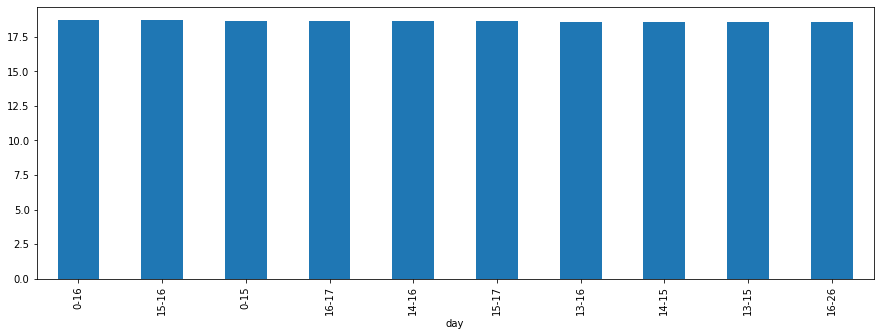

In [9]:
profit_df.Cardano.sort_values(ascending=False).head(10).plot(kind='bar')

The plot suggests that for the coin in question, the best combination of days is 0-16. However it is interesting to observe that the top 10 combinations can be grouped in 3 categories:
* Buying in the middle and at the end/beginning
* Buying both times in the middle

This suggests that half way through the month is a good spot to buy, even twice. Otherwise it is better to distantiate the purchases of two weeks, either starting at the beginning or the middle.

In [10]:
profit_df.Cardano.idxmax()

'0-16'

The pair that maximises the profits is 0-16 (first day of the month and the 17th).